In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import dask.array as da
import pyproj

pd.set_option("display.max_rows", 200)
import pdb

from pycontrails import Flight, Fleet, MetDataset
from pycontrails.core import models
from pycontrails.datalib.ecmwf import ERA5
from pycontrails.physics import geo, thermo, units, constants

# from pycontrails.models.ps_model import PSFlight
# from pycontrails.models.emissions import Emissions
from pycontrails.ext.flight_gen import FlightGen
from pycontrails.models.boxmodel.boxm import Boxm

# from pycontrails.models.dry_advection import DryAdvection
from pycontrails.core.met_var import (
    AirTemperature,
    RelativeHumidity,
    SpecificHumidity,
    EastwardWind,
    NorthwardWind,
    VerticalVelocity,
)

In [2]:
# meteorological parameters
met_params = {
    "air_temperature": 240.0,  # K
    "specific_humidity": 0.001,  # 1
    "relative_humidity": 0.5,  # 1
    "eastward_wind": 0.0,  # m/s
    "northward_wind": 0.0,  # m/s
    "lagrangian_tendency_of_air_pressure": 0.0,  # m/s
}

In [3]:
# flight trajectory parameters
fl_params = {
    "t0_fl": pd.to_datetime("2022-03-02 14:00:00"),  # flight start time
    "rt_fl": pd.Timedelta(minutes=30),  # flight run time
    "ts_fl": pd.Timedelta(minutes=2),  # flight time step
    "ac_type": "A320",  # aircraft type
    "fl0_speed": 100.0,  # m/s
    "fl0_heading": 45.0,  # deg
    "fl0_coords0": (-0.8, -0.8, 11500),  # lat, lon, alt [deg, deg, m]
    "sep_dist": (5000, 2000, 0),  # dx, dy, dz [m]
    "n_ac": 1,  # number of aircraft
}

In [4]:
# plume dispersion parameters
plume_params = {
    "dt_integration": pd.Timedelta(minutes=5),  # integration time step
    "max_age": pd.Timedelta(hours=2),  # maximum age of the plume
    "depth": 50.0,  # initial plume depth, [m]
    "width": 50.0,  # initial plume width, [m]
    "shear": 0.005,  # wind shear [1/s]
}

In [5]:
# chemistry sim parameters
chem_params = {
    "t0_chem": pd.to_datetime("2022-03-01 21:00:00"),  # chemistry start time
    "rt_chem": pd.Timedelta(days=1),  # chemistry runtime
    "ts_chem": pd.Timedelta(minutes=5),  # chemistry time step
    "lat_bounds": (-1.0, 0.0),  # lat bounds [deg]
    "lon_bounds": (-1.0, 0.0),  # lon bounds [deg]
    "alt_bounds": (11000, 12000),  # alt bounds [m]
    "hres_chem": 0.1,  # horizontal resolution [deg]
    "vres_chem": 500,  # vertical resolution [m]
}

In [6]:
# create lists for lats, lons, alts, and times based on chem params
lats = np.arange(
    chem_params["lat_bounds"][0], chem_params["lat_bounds"][1] + chem_params["hres_chem"], chem_params["hres_chem"]
)

lons = np.arange(
    chem_params["lon_bounds"][0], chem_params["lon_bounds"][1] + chem_params["hres_chem"], chem_params["hres_chem"]
)

alts = np.arange(
    chem_params["alt_bounds"][0], chem_params["alt_bounds"][1] + chem_params["vres_chem"], chem_params["vres_chem"]
)

times = pd.date_range(
    start=chem_params["t0_chem"],
    end=chem_params["t0_chem"] + chem_params["rt_chem"],
    freq=chem_params["ts_chem"],
)


In [7]:
# generate artifical met dataset (boxm currently only supports zero-wind scenarios)
data_vars = {
    param: (
        ["longitude", "latitude", "level", "time"],
        da.full(
            (len(lons), len(lats), len(alts), len(times)),
            value,
            chunks=(len(lons), len(lats), len(alts), 100),
        ),
    )
    for param, value in met_params.items()
}

met = xr.Dataset(
    data_vars,
    coords={"longitude": lons, "latitude": lats, "level": units.m_to_pl(alts), "time": times},
)

met = MetDataset(met)

met

MetDataset with data:

<xarray.Dataset> Size: 5MB
Dimensions:                              (longitude: 11, latitude: 11,
                                          level: 3, time: 289)
Coordinates:
  * longitude                            (longitude) float64 88B -1.0 ... -2....
  * latitude                             (latitude) float64 88B -1.0 ... -2.2...
  * level                                (level) float64 24B 193.3 209.2 226.3
  * time                                 (time) datetime64[ns] 2kB 2022-03-01...
    air_pressure                         (level) float64 24B 1.933e+04 ... 2....
    altitude                             (level) float64 24B 1.2e+04 ... 1.1e+04
Data variables:
    air_temperature                      (longitude, latitude, level, time) float64 839kB dask.array<chunksize=(11, 11, 3, 100), meta=np.ndarray>
    specific_humidity                    (longitude, latitude, level, time) float64 839kB dask.array<chunksize=(11, 11, 3, 100), meta=np.ndarray>
    relative_humidity                    (longitude, latitude, level, time) float64 839kB dask.array<chunksize=(11, 11, 3, 100), meta=np.ndarray>
    eastward_wind                        (longitude, latitude, level, time) float64 839kB dask.array<chunksize=(11, 11, 3, 100), meta=np.ndarray>
    northward_wind                       (longitude, latitude, level, time) float64 839kB dask.array<chunksize=(11, 11, 3, 100), meta=np.ndarray>
    lagrangian_tendency_of_air_pressure  (longitude, latitude, level, time) float64 839kB dask.array<chunksize=(11, 11, 3, 100), meta=np.ndarray>

In [8]:
# instantiate FlightGen object
fl_gen = FlightGen(met, fl_params, plume_params, chem_params)

In [9]:
fl = fl_gen.traj_gen()

fl

[Flight [4 keys x 10 length, 3 attributes]
 	Keys: longitude, latitude, altitude, time
 	Attributes:
 	time                [2022-03-02 14:00:00, 2022-03-02 14:18:00]
 	longitude           [-0.8, -0.114]
 	latitude            [-0.8, -0.109]
 	altitude            [11500.0, 11500.0]
 	flight_id           0
 	aircraft_type       A320
 	crs                 EPSG:4326]

In [10]:
# estimate fuel burn and emissions using ps_model and emissions model
fl = fl_gen.calc_fb_emissions()


Calculating CO2 emissions indices: 3.16
Calculating H2O emissions indices: 1.23
Calculating SO2 emissions indices: 0.00084
Calculating nvPM emissions indices: [7.17e-05 7.17e-05 7.17e-05 7.17e-05 7.17e-05 7.17e-05 7.17e-05 7.17e-05
 7.17e-05      nan]
Calculating NO emissions indices: [0.01260816 0.01260816 0.01260816 0.01260816 0.01260816 0.01260816
 0.01260816 0.01260816 0.01260816        nan]
Calculating NO2 emissions indices: [0.00066359 0.00066359 0.00066359 0.00066359 0.00066359 0.00066359
 0.00066359 0.00066359 0.00066359        nan]
Calculating CO emissions indices: [0.0005606 0.0005606 0.0005606 0.0005606 0.0005606 0.0005606 0.0005606
 0.0005606 0.0005606       nan]
Calculating HCHO emissions indices: [6.56316157e-06 6.56316157e-06 6.56316157e-06 6.56316157e-06
 6.56316157e-06 6.56316157e-06 6.56316157e-06 6.56316157e-06
 6.56316157e-06            nan]
Calculating CH3CHO emissions indices: [2.18772052e-06 2.18772052e-06 2.18772052e-06 2.18772052e-06
 2.18772052e-06 2.18772052e

/home/ktait98/pycontrails_kt/pycontrails/ext/flight_gen.py:128: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  flights[i].dataframe[column] = flights[i].dataframe[column].fillna(method='ffill')


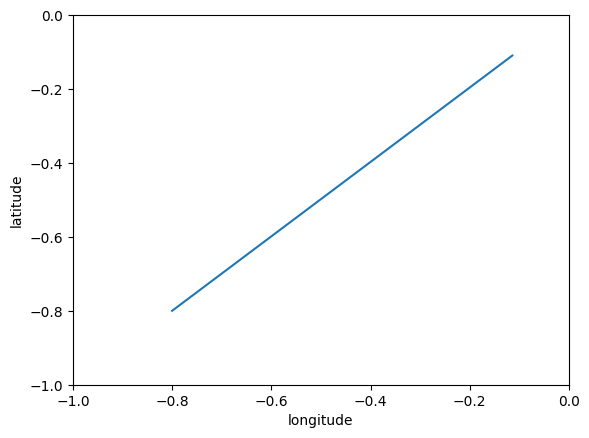

In [11]:
# visualise the fleet
ax = plt.axes()
ax.set_xlim([lons[0], lons[-1]])
ax.set_ylim([lats[0], lats[-1]])
for i in fl:
    i.plot(ax=ax)

In [12]:
# simulate plume dispersion/advection using dry advection model
fl_df, pl_df = fl_gen.sim_plumes()

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 30)

fl_df

/home/ktait98/pycontrails_kt/pycontrails/ext/flight_gen.py:183: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  flights[i][column] = flights[i][column].fillna(method='ffill')


,longitude,latitude,altitude,time,air_temperature,specific_humidity,true_airspeed,flight_id,aircraft_mass,engine_efficiency,fuel_flow,fuel_burn,thrust,rocd,fuel_flow_per_engine,...,nvpm_number,CO2,H2O,SO2,nvPM,NO,NO2,CO,HCHO,CH3CHO,C2H4,C3H6,C2H2,BENZENE,waypoint
0,-0.800000,-0.800000,11500.0,2022-03-02 14:00:00,240.0,0.001,100.226641,0.0,60355.747889,0.099498,0.869221,104.306539,86971.857009,0.0,0.434611,...,1.136941e+17,0.000001,4.266898e-07,2.913979e-10,2.487289e-11,4.373800e-09,2.302000e-10,1.944746e-10,2.276775e-12,7.589251e-13,2.845969e-12,7.589251e-13,7.589251e-13,3.794626e-13,0
1,-0.723776,-0.723258,11500.0,2022-03-02 14:02:00,240.0,0.001,100.227482,0.0,60251.441351,0.099499,0.869221,104.306502,86683.787706,0.0,0.434610,...,1.136941e+17,0.000001,4.266860e-07,2.913953e-10,2.487267e-11,4.373762e-09,2.301980e-10,1.944729e-10,2.276756e-12,7.589185e-13,2.845944e-12,7.589185e-13,7.589185e-13,3.794593e-13,1
2,-0.647552,-0.646515,11500.0,2022-03-02 14:04:00,240.0,0.001,100.228235,0.0,60147.134849,0.099500,0.869221,104.306470,86396.366660,0.0,0.434610,...,1.136941e+17,0.000001,4.266827e-07,2.913931e-10,2.487248e-11,4.373728e-09,2.301962e-10,1.944713e-10,2.276738e-12,7.589126e-13,2.845922e-12,7.589126e-13,7.589126e-13,3.794563e-13,2
3,-0.571328,-0.569773,11500.0,2022-03-02 14:06:00,240.0,0.001,100.228898,0.0,60042.828379,0.099500,0.869220,104.306441,86109.592281,0.0,0.434610,...,1.136940e+17,0.000001,4.266797e-07,2.913910e-10,2.487231e-11,4.373698e-09,2.301946e-10,1.944700e-10,2.276722e-12,7.589074e-13,2.845903e-12,7.589074e-13,7.589074e-13,3.794537e-13,3
4,-0.495104,-0.493031,11500.0,2022-03-02 14:08:00,240.0,0.001,100.229471,0.0,59938.521938,0.099501,0.869220,104.306416,85823.462986,0.0,0.434610,...,1.136940e+17,0.000001,4.266772e-07,2.913893e-10,2.487216e-11,4.373671e-09,2.301932e-10,1.944688e-10,2.276708e-12,7.589028e-13,2.845886e-12,7.589028e-13,7.589028e-13,3.794514e-13,4
5,-0.418881,-0.416289,11500.0,2022-03-02 14:10:00,240.0,0.001,100.229956,0.0,59834.215522,0.099502,0.869220,104.306395,85537.977196,0.0,0.434610,...,1.136940e+17,0.000001,4.266751e-07,2.913878e-10,2.487203e-11,4.373649e-09,2.301921e-10,1.944679e-10,2.276697e-12,7.588990e-13,2.845871e-12,7.588990e-13,7.588990e-13,3.794495e-13,5
6,-0.342657,-0.339546,11500.0,2022-03-02 14:12:00,240.0,0.001,100.230351,0.0,59729.909127,0.099502,0.869220,104.306378,85252.665603,0.0,0.434610,...,1.136940e+17,0.000001,4.266733e-07,2.913866e-10,2.487193e-11,4.373631e-09,2.301911e-10,1.944671e-10,2.276688e-12,7.588959e-13,2.845860e-12,7.588959e-13,7.588959e-13,3.794479e-13,6
7,-0.266433,-0.262804,11500.0,2022-03-02 14:14:00,240.0,0.001,100.229717,0.0,59625.602750,0.099502,0.869220,104.306405,84969.934151,0.0,0.434610,...,1.136940e+17,0.000001,4.266761e-07,2.913886e-10,2.487210e-11,4.373660e-09,2.301926e-10,1.944684e-10,2.276703e-12,7.589009e-13,2.845878e-12,7.589009e-13,7.589009e-13,3.794504e-13,7
8,-0.190212,-0.186060,11500.0,2022-03-02 14:16:00,240.0,0.001,100.228994,0.0,59521.296344,0.099501,0.869220,104.306437,84688.233511,0.0,0.434610,...,1.136940e+17,0.000001,4.266793e-07,2.913908e-10,2.487228e-11,4.373693e-09,2.301944e-10,1.944698e-10,2.276720e-12,7.589066e-13,2.845900e-12,7.589066e-13,7.589066e-13,3.794533e-13,8
9,-0.113994,-0.109315,11500.0,2022-03-02 14:18:00,240.0,0.001,100.228994,0.0,59416.989908,0.099501,0.869220,104.306437,84688.233511,0.0,0.434610,...,1.136940e+17,0.000001,4.266793e-07,2.913908e-10,2.487228e-11,4.373693e-09,2.301944e-10,1.944698e-10,2.276720e-12,7.589066e-13,2.845900e-12,7.589066e-13,7.589066e-13,3.794533e-13,9


In [13]:
fl_gen.anim_fl(fl_df, pl_df)

In [14]:
# convert plume dataframe to EMI geospatial xarray dataset
emi = fl_gen.plume_to_grid(lats, lons, alts, times)



Processing time:  2022-03-02 14:05:00


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Processing time:  2022-03-02 14:10:00


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Processing time:  2022-03-02 14:15:00


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Processing time:  2022-03-02 14:20:00


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Processing time:  2022-03-02 14:25:00


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Processing time:  2022-03-02 14:30:00


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Processing time:  2022-03-02 14:35:00


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Processing time:  2022-03-02 14:40:00


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Processing time:  2022-03-02 14:45:00


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Processing time:  2022-03-02 14:50:00


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Processing time:  2022-03-02 14:55:00


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Processing time:  2022-03-02 15:00:00


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Processing time:  2022-03-02 15:05:00


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Processing time:  2022-03-02 15:10:00


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Processing time:  2022-03-02 15:15:00


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Processing time:  2022-03-02 15:20:00


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Processing time:  2022-03-02 15:25:00


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Processing time:  2022-03-02 15:30:00


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Processing time:  2022-03-02 15:35:00


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Processing time:  2022-03-02 15:40:00


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Processing time:  2022-03-02 15:45:00


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Processing time:  2022-03-02 15:50:00


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Processing time:  2022-03-02 15:55:00


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Processing time:  2022-03-02 16:00:00


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Processing time:  2022-03-02 16:05:00


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Processing time:  2022-03-02 16:10:00


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Processing time:  2022-03-02 16:15:00


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [15]:
#emi.data.sel(emi_species="NO", latitude=-0.8, longitude=-0.8).compute()
emi["emi"].data.loc[:, :, :, :, "NO"] #.sel(emi_species="NO").isel(time=0).sel(level=units.m_to_pl(11500), method="nearest").plot()

<xarray.DataArray 'emi' (longitude: 11, latitude: 11, level: 3, time: 289)> Size: 839kB
array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
...
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]]])
Coordinates:
  * longitude     (longitude) float64 88B -1.0 -0.9 -0.8 ... -0.2 -0.1 -2.22e-16
  * latitude      (latitude) float64 88B -1.0 -0.9 -0.8 ... -0.2 -0.1 -2.22e-16
  * level         (level) float64 24B 193.3 209.2 226.3
  * time          (time) datetime64[ns] 2kB 2022-03-01T21:00:00 ... 2022-03-0...
    emi_species   <U7 28B 'NO'
    air_pressure  (level) float64 24B 1.933e+04 2.092e+04 2.263e+04
    altitude      (level) float64 24B 1.2e+04 1.15e+04 1.1e+04

In [16]:
# init boxm simulation and generate chemistry dataset
boxm = Boxm(met=met, params=chem_params)

/home/ktait98/miniconda3/envs/contrails/lib/python3.12/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [17]:
# run boxm simulation
chem = boxm.eval(emi)

In [18]:
boxm.boxm_input["M"].isel(time=0).sel(level=units.m_to_pl(11500), method="nearest").values

array([[6.31216217e+18, 6.31216217e+18, 6.31216217e+18, 6.31216217e+18,
        6.31216217e+18, 6.31216217e+18, 6.31216217e+18, 6.31216217e+18,
        6.31216217e+18, 6.31216217e+18, 6.31216217e+18],
       [6.31216217e+18, 6.31216217e+18, 6.31216217e+18, 6.31216217e+18,
        6.31216217e+18, 6.31216217e+18, 6.31216217e+18, 6.31216217e+18,
        6.31216217e+18, 6.31216217e+18, 6.31216217e+18],
       [6.31216217e+18, 6.31216217e+18, 6.31216217e+18, 6.31216217e+18,
        6.31216217e+18, 6.31216217e+18, 6.31216217e+18, 6.31216217e+18,
        6.31216217e+18, 6.31216217e+18, 6.31216217e+18],
       [6.31216217e+18, 6.31216217e+18, 6.31216217e+18, 6.31216217e+18,
        6.31216217e+18, 6.31216217e+18, 6.31216217e+18, 6.31216217e+18,
        6.31216217e+18, 6.31216217e+18, 6.31216217e+18],
       [6.31216217e+18, 6.31216217e+18, 6.31216217e+18, 6.31216217e+18,
        6.31216217e+18, 6.31216217e+18, 6.31216217e+18, 6.31216217e+18,
        6.31216217e+18, 6.31216217e+18, 6.31216217e+

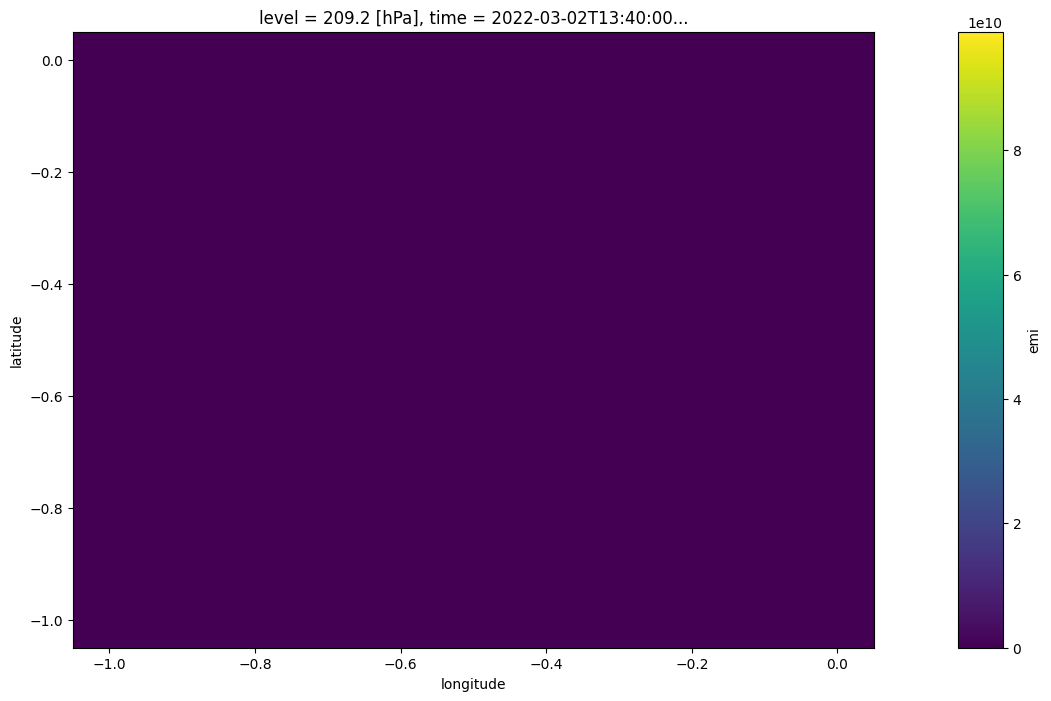

In [19]:
mda = boxm.boxm_input["emi"].isel(time=slice(200, 250)).sel(emi_species="NO").sel(level=units.m_to_pl(11500), method="nearest").compute()
boxm.anim_chem(mda)

In [20]:
boxm.boxm_input["emi"].sel(emi_species="NO").sel(level=units.m_to_pl(11500), method="nearest").max().values

array(9.90350087e+10)